In [7]:
%matplotlib inline

import sys
sys.path.insert(0, '../python/casadi_f16')
import f16
import control
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

from analysis import loop_analysis, rlocus, bode

plt.rcParams['figure.figsize'] = (10, 10)

# Pitch-Rate CAS Design

* Example 4.5-1
* pg. 310

In [8]:
p = f16.Parameters()
x0, u0 = f16.trim(x=f16.State(VT=550), p=p, phi_dot=0, theta_dot=0, psi_dot=0.0, gam=0)

In [9]:
def f_control(t, x):
    return f16.Control(
        thtl=u0.thtl,
        ail_cmd_deg=u0.ail_cmd_deg,
        elv_cmd_deg=u0.elv_cmd_deg + 1*np.sin(2*np.pi*2*t),
        rdr_cmd_deg=u0.rdr_cmd_deg)

f_control(0, x0)

Control(thtl=DM(0.166459), ail_cmd_deg=DM(0), elv_cmd_deg=DM(-0.807378), rdr_cmd_deg=DM(0))

Text(0.5, 1.0, 'angle of attack')

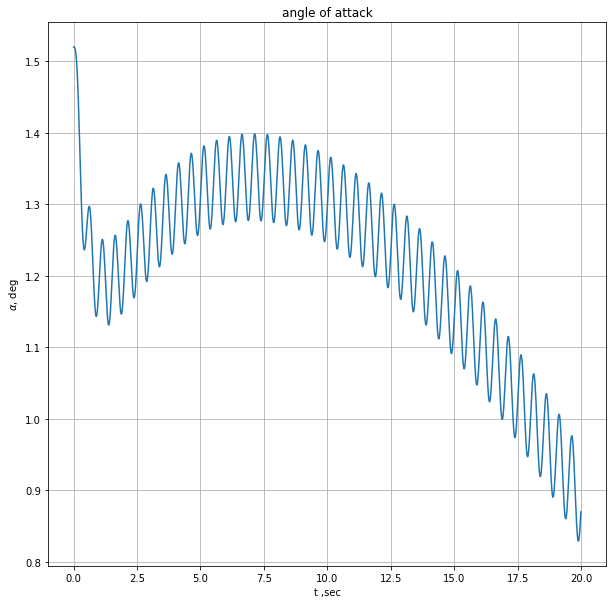

In [10]:
res = f16.simulate(x0, f_control, p, 0, 20, 0.01)
plt.plot(res['t'], np.rad2deg(res['x'][:, f16.State().name_to_index('alpha')]))
plt.xlabel('t ,sec')
plt.ylabel(r'$\alpha$, deg')
plt.grid()
plt.title('angle of attack')

Text(0.5, 1.0, 'trajectory')

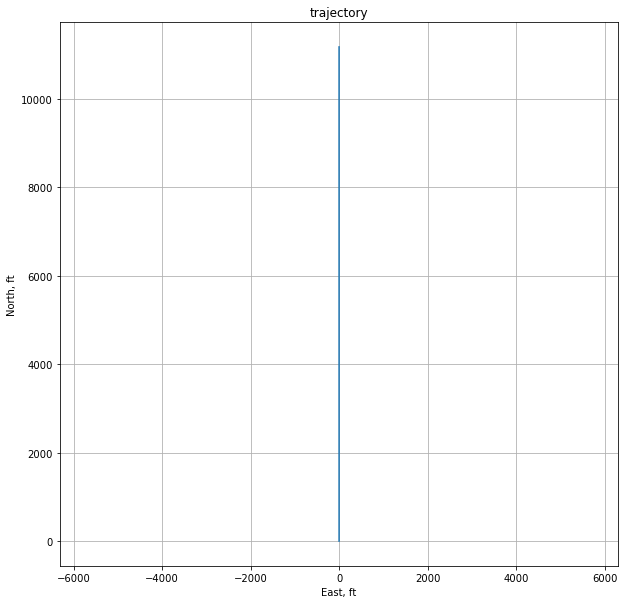

In [11]:
res = f16.simulate(x0, f_control, p, 0, 20, 0.01)

plt.plot(res['x'][:, f16.State().name_to_index('p_E')], res['x'][:, f16.State().name_to_index('p_N')])
plt.axis('equal');
plt.xlabel('East, ft')
plt.ylabel('North, ft')
plt.grid()
plt.title('trajectory')

In [12]:
def f_control(t, x):
    print(x)
    return f16.Control(
        thtl=u0.thtl,
        ail_cmd_deg=u0.ail_cmd_deg,
        elv_cmd_deg=u0.elv_cmd_deg + 1*np.sin(2*np.pi*2*t),
        rdr_cmd_deg=u0.rdr_cmd_deg)

In [13]:
def select(n, i):
    D = np.zeros((1, n))
    D[0, i] = 1
    return control.ss([], [], [], D)

In [14]:
ss = f16.linearize(x0, u0, p)
s = control.tf([1, 0], [0, 1])
G = -(180/np.pi)*ss.sub_system(x=['alpha', 'Q', 'elv_deg'],
                  u=['elv_cmd_deg'], y=['alpha', 'Q']).to_control()
sys3 = control.feedback(G, 0.2*10/(s+10)*select(2, 0))
sys3

A = [[-1.11607665e+00  9.06007222e-01 -2.35158696e-03  0.00000000e+00]
 [ 9.85813115e-01 -1.17939983e+00 -2.10904761e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.02020000e+01  2.31497868e+03]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e+01]]

B = [[    0.        ]
 [    0.        ]
 [-1157.48933772]
 [    0.        ]]

C = [[1. 0. 0. 0.]
 [0. 1. 0. 0.]]

D = [[0.]
 [0.]]

3 states have been removed from the model


[-21, 0, -8, 8]

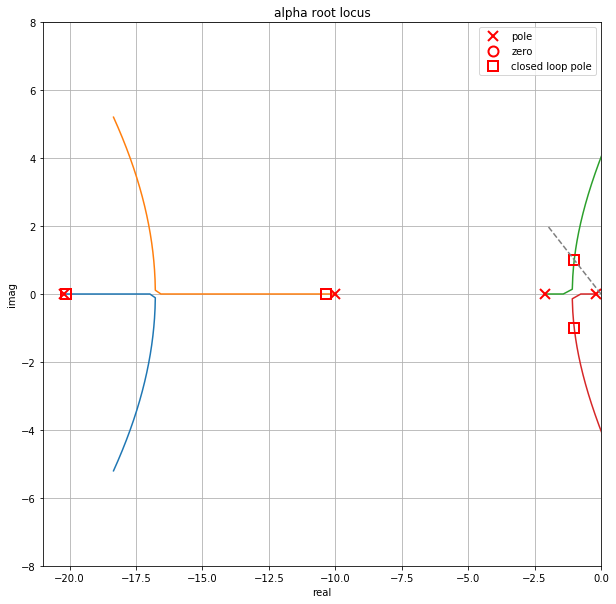

In [50]:
from analysis import rlocus
H = (10/(s+10))*select(2, 0)
plt.figure()
kalpha = 0.15
rlocus('alpha', control.minreal(H*G), kvect=np.linspace(0, 10, 1000), k=kalpha);
plt.plot([0, -2], [0, 2], '--')
plt.axis([-21, 0, -8, 8])

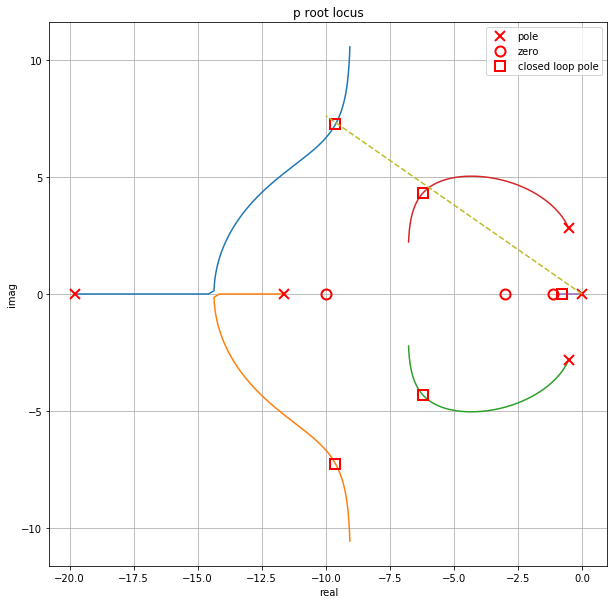

In [54]:
plt.figure()
kpitch=.8
sys3 = control.feedback(G, kpitch*(10/(s+10))*select(2, 0))
rlocus('p', (s+3)/s*sys3[1, 0], kvect=np.linspace(0, 1, 1000), k=kpitch)
plt.plot([0, -10], [0, 10*np.cos(0.707)], '--')
#plt.axis([-20, 0, -5, 5])

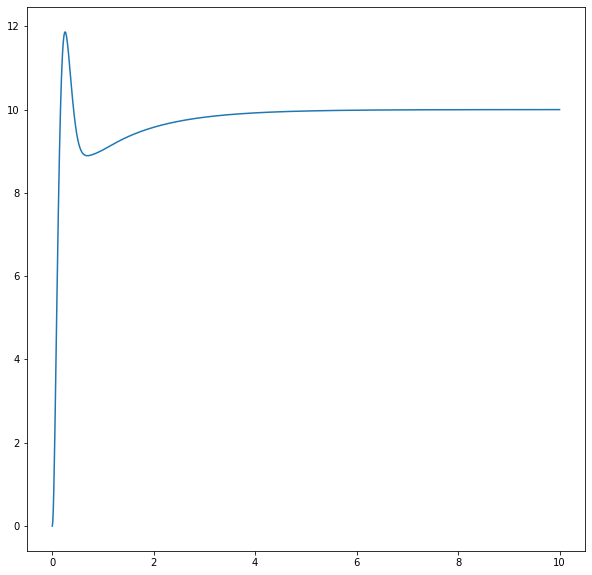

In [55]:
H_PI=1+3/s
Go=H_PI*sys3[1,0]
Gc=control.feedback(Go,1)
t,y=control.step_response(Gc, T=np.linspace(0,10,1000))
plt.plot(t,10*y)

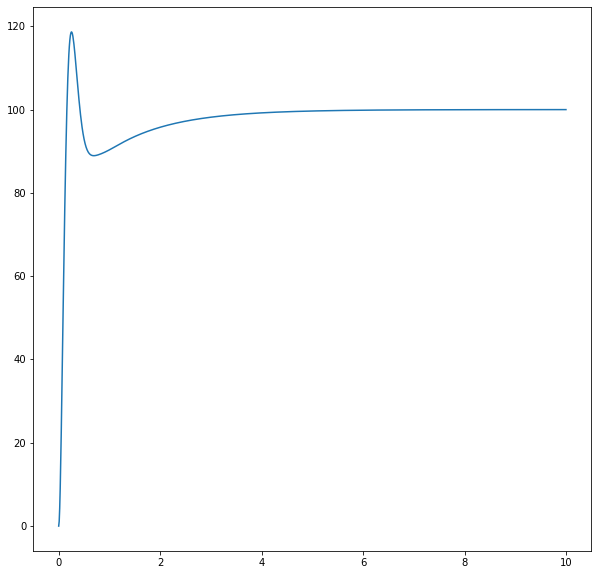

In [56]:
plt.plot(t,100*y)

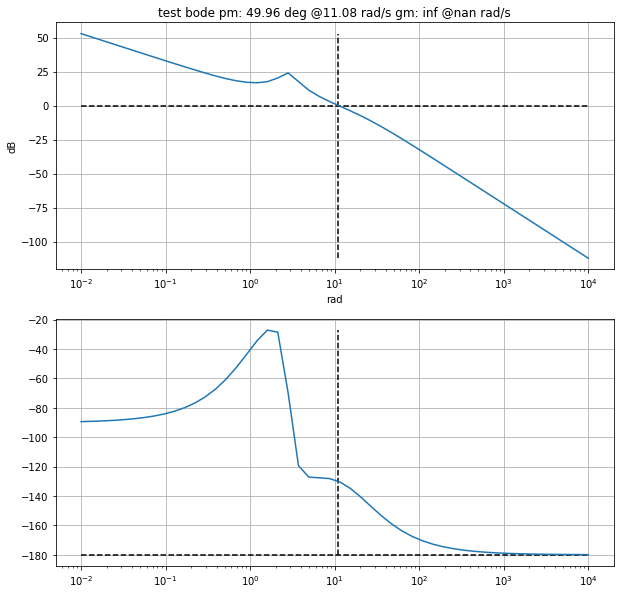

In [57]:
bode('test', (s+3)/s*sys3[1, 0], omega=np.logspace(-2, 4), margins=True)

In [58]:
def step_info(t,yout):
    print ("OS: {0}".format(((yout.max()/yout[-1]-1)*100,'%')))
    print ("Tr: {0}".format((t[next(i for i in range(0,len(yout)-1) if yout[i]>yout[-1]*.90)]-t[0])))
    print ("Ts: {0}".format((t[next(len(yout)-i for i in range(2,len(yout)-1) if abs(yout[-i]/yout[-1])>1.02)]-t[0])))

In [59]:
step_info(t,y)

OS: (18.65629870355758, '%')
Tr: 0.15015015015015015
Ts: 0.40040040040040037
